[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


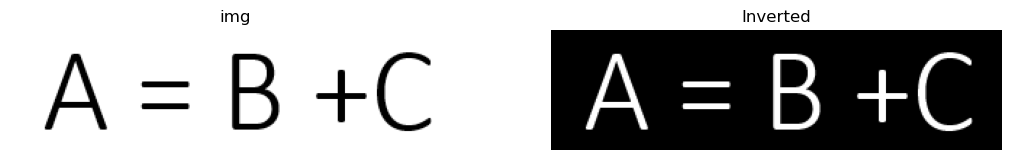

In [33]:
from commonfunctions import *
from skimage.color import rgba2rgb

img  = io.imread('test_images/1.png')
img = rgba2rgb(img)
img = rgb2gray(img)

print(img)

img_inv = 1- img
show_images([img,img_inv],['img','Inverted'])

In [93]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load the image
img = cv2.imread('test_images/1.png')

# convert to grayscale
gray = 255- cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# smooth the image to avoid noises
# gray = cv2.medianBlur(gray,5)
# Apply adaptive threshold
# thresh = cv2.adaptiveThreshold(gray, 255, 1, 1, 11, 2)
# thresh_color = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

# # apply some dilation and erosion to join the gaps
# kernel = np.ones((5,5), np.uint8)
# thresh = cv2.dilate(thresh, kernel ,iterations = 2)
# thresh = cv2.erode(thresh, kernel, iterations = 2)



In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Load the image
img = cv2.imread('test_images/1.png')

# convert to grayscale
gray = 255- cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
h,w = gray.shape
tolerance = 0.01 * w
# Find the contours
contours,hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = list(filter(lambda cnt: cv2.contourArea(cnt,True) < 0 , contours))
# sort contours from left to right
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
# For each contour, find the bounding rectangle and draw it
contours_list = [(x,y,w,h) for x,y,w,h in [cv2.boundingRect(c) for c in contours]]

#sort contours from left to right
contours_list = sorted(contours_list, key=lambda ctr: ctr[0])
# merge list that are too close in x axis

def union(a,b):
    x = min(a[0], b[0])
    y = min(a[1], b[1])
    w = max(a[0]+a[2], b[0]+b[2]) - x
    h = max(a[1]+a[3], b[1]+b[3]) - y
    return (x, y, w, h)

for ind,(x,y,w,h) in enumerate(contours_list):
    prev_x = -tolerance - 20  if ind == 0 else contours_list[ind-1][0]   
    if x - prev_x < tolerance:
        contours_list[ind] = union(contours_list[ind],contours_list[ind-1])
        contours_list.remove(contours_list[ind-1])
        ind -=1
        x,y,w,h = contours_list[ind]
        
    
# For each contour, find the bounding rectangle and draw it
for ind,(x,y,w,h) in enumerate(contours_list):
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),1)
    cv2.putText(img, str(ind), (x,y), cv2.FONT_ITALIC, 1, (0,0,255), 2, cv2.LINE_AA)



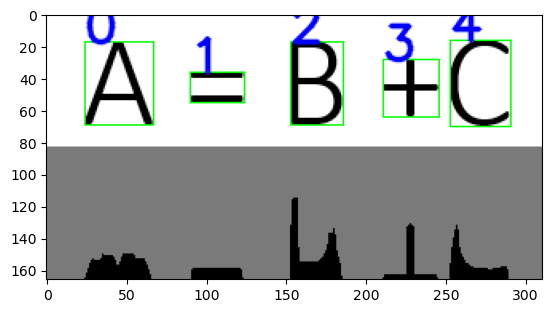

In [31]:
# Width and heigth the image
height, width = gray.shape
# Sum the value lines 
vertical_px = np.sum(gray, axis=0)
# Normalize
normalize = vertical_px/255
# create a black image with zeros 
blankImage = np.zeros_like(gray)
# Make the vertical projection histogram
for idx, value in enumerate(normalize):
    cv2.line(blankImage, (idx, 0), (idx, height-int(value)), (122,255,200), 1)
# Concatenate the image
img_concate = cv2.vconcat([img,  cv2.cvtColor(blankImage, cv2.COLOR_BGR2RGB)])

plt.imshow(img_concate)
plt.show()

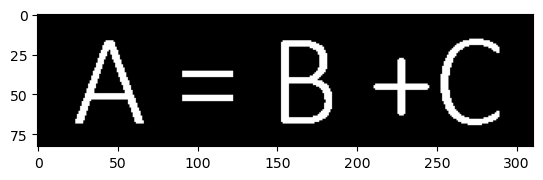

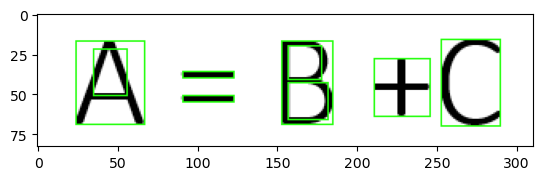

In [21]:
import cv2
from imutils import contours
import matplotlib.pyplot as plt

image = cv2.imread('./test_images/1.png')
gray =255-  cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]

cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

ROI_number = 0
for c in cnts:
    area = cv2.contourArea(c)
    if area > 10:
        x,y,w,h = cv2.boundingRect(c)
        ROI = 255 - thresh[y:y+h, x:x+w]
        # cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
        cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 1)
        ROI_number += 1
# plt.imshow('thresh', thresh)
plt.imshow(thresh)
plt.show()
plt.imshow(image)
# plt.imshow('image', image)
# cv2.waitKey()

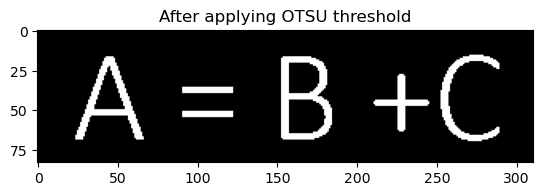

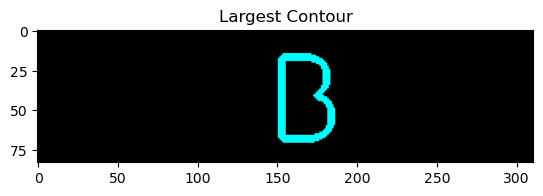

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 array([[[154,  17]],
 
        [[153,  18]],
 
        [[153,  19]],
 
        [[153,  20]],
 
        [[153,  21]],
 
        [[153,  22]],
 
      

In [7]:
def apply_threshold(filtered):
    """
    Apply OTSU threshold
    Args:
        filtered: np.array
    Returns:
        thresh: np.array
    """
    ret, thresh = cv2.threshold(filtered, 250, 255, cv2.THRESH_OTSU)
    plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
    plt.title('After applying OTSU threshold')
    plt.show()
    return thresh

def detect_contour(img, image_shape):
    """
    Args:
        img: np.array()
        image_shape: tuple
    Returns:
        canvas: np.array()
        cnt: list
    """
    canvas = np.zeros(image_shape, np.uint8)
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cnt = sorted(contours, key=cv2.contourArea, reverse=True)[0]
    cv2.drawContours(canvas, cnt, -1, (0, 255, 255), 3)
    plt.title('Largest Contour')
    plt.imshow(canvas)
    plt.show()

    return canvas, cnt

image = cv2.imread('./test_images/1.png')
gray = 255 - cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]
thresh = apply_threshold(thresh)
detect_contour(thresh, image.shape)
